# Data Engineering setup for Part 1



In [98]:
# Importing necessary libraries for data cleaning and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from Utils.preprocessing import *
from Utils.customPipelines import *

RANDOM_STATE=2024

In [2]:
# Load the dataset
file_path = 'Data/QF632_Project_1.csv'
df = pd.read_csv(file_path)

# Expected data types
expected_types = {
        'Date': 'datetime64[ns]',
        'Signal': 'float64',
        'Open': 'float64',
        'High': 'float64',
        'Low': 'float64',
        'Close': 'float64',
        'Adj Close': 'float64',
}

# Examine the structure and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1038 non-null   object 
 1   Signal     1038 non-null   float64
 2   Open       1038 non-null   float64
 3   High       1038 non-null   float64
 4   Low        1038 non-null   float64
 5   Close      1038 non-null   float64
 6   Adj Close  1038 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.9+ KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   132.132496   132.912495   130.542503   131.824993   
50%      17.298240   146.769997 

# Table of Contents <a name="tableofcontents"></a>
1. [Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.](#part1)
2. [Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.](#part2)
3. [Run any exploratory data analysis you think is important and highlight any interesting insights you come across. ](#part3)

# part1 
Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

a.	Check object types

b.	Check for nan values

    i.	Interpolate or forward fill. If interpolate, be careful not to include future rows 

c.	Difference all first

d.	Scatter plot/boxplot for outliers

    i.	See if need outlier handling (If no, maybe justify why)


In [3]:
def length_test(df):
    """
    Check the length of the dataset.
    
    Returns:
        bool: True if the dataframe is not empty, False otherwise.
    """
    return len(df) > 0

In [4]:
def missing_test(df):
    """
    Check for missing values in the dataframe.
    
    Returns:
        bool: True if there are missing values, False otherwise.
    """
    # return df.isnull().sum() > 0
    return df.isnull().values.any()

In [5]:
def duplicate_test(df):
    """
    Check for duplicated rows in the dataframe.
    
    Returns:
        bool: True if no duplicates are found, False otherwise.
        pd.DataFrame: Dataframe with duplicates dropped if any were found.
    """
    duplicated_rows = df[df.duplicated()]
    result = duplicated_rows.empty
    if not result:
        df = df.drop_duplicates()
    return result, df

In [6]:
def date_test(df):
    """
    Ensure dates are in the right format and sequence.

    Args:
        df (pd.DataFrame): The dataframe to check.

    Returns:
        tuple: (bool, int, bool) - 
            True if all dates are in the datetime64[ns] format, False otherwise.
            The number of invalid dates found.
            True if dates are in ascending order, False otherwise.
    """
    # Convert 'Date' column to datetime64[ns]
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Check for invalid dates and format
    invalid_dates_count = df['Date'].isnull().sum()
    correct_format = invalid_dates_count == 0
    
    # Check for date sequence issues
    date_sequence_check = df['Date'].is_monotonic_increasing
    
    return correct_format, invalid_dates_count, date_sequence_check

In [7]:
def datatype_test(df, expected_types):
    """
    Checks if the data types in the dataframe match the expected types.

    Args:
        df (pd.DataFrame): The dataframe to check.
        expected_types (dict): A dictionary mapping column names to 
            expected data types (e.g., {'Date': 'datetime64[ns]', 'Price': 'float64'})

    Returns:
        tuple: (bool, list) - 
            True if all data types match, False otherwise.
            A list of error messages for mismatched data types.
    """
    errors = []
    for col, expected_type in expected_types.items():
        if col in df.columns:
            if df[col].dtype != expected_type:
                errors.append(f"Column '{col}' is of type {df[col].dtype} but expected {expected_type}.")
    return len(errors) == 0, errors

In [8]:
def correct_data_types(df, expected_types):
    """
    Corrects data types in the dataframe according to the expected types.

    Args:
        df (pd.DataFrame): The dataframe to correct.
        expected_types (dict): A dictionary mapping column names to 
            expected data types (e.g., {'Date': 'datetime64[ns]', 'Price': 'float64'})

    Returns:
        pd.DataFrame: Dataframe with corrected data types.
    """
    for col, expected_type in expected_types.items():
        if col in df.columns:
            if df[col].dtype != expected_type:
                # Attempt conversion with coerce
                try:
                    if expected_type == 'datetime64[ns]':
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    else:
                        df[col] = pd.to_numeric(df[col], errors='coerce').astype(expected_type)
                except Exception as e:
                    # Handle conversion errors
                    print(f"Failed to convert column '{col}' to {expected_type}: {e}")
    return df

In [9]:
def nan_values_test(df):
    """
    Check for NaN values in the dataframe.

    Returns:
        bool: True if all values are valid non-NaN values, False otherwise.
        list: List of error messages for columns containing NaN values.
    """
    errors = []
    nan_summary = df.isna().sum()
    nan_columns = nan_summary[nan_summary > 0].index.tolist()

    if len(nan_columns) == 0:
        return True, errors

    for column in nan_columns:
        errors.append(f"Column '{column}' has {nan_summary[column]} NaN values.")

    return False, errors

In [10]:
def correct_nan_values(df):
    """
    Correct NaN values in the dataframe by interpolating them.
    
    Returns:
        pd.DataFrame: Dataframe with NaN values corrected.
    """
    columns = [col for col in df.columns if col != 'Date']
    for col in columns:
        if df[col].isnull().any():
            df[col] = df[col].interpolate(method='linear', limit_direction='both')
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    return df

In [11]:
def non_positive_test(df):
    """
    Check for non-positive values in numeric columns.
    
    Returns:
        bool: True if all values are positive, False otherwise.
        dict: Dictionary with counts of non-positive values per column.
    """
    columns = [col for col in df.columns if col != 'Date']
    non_positive_values = {col: (df[col] <= 0).sum() for col in columns}
    result = all(value == 0 for value in non_positive_values.values())
    return result, non_positive_values

In [12]:
def correct_non_positive_values(df):
    """
    Correct non-positive values in the dataframe by interpolating them.
    
    Returns:
        pd.DataFrame: Dataframe with non-positive values corrected.
    """
    columns = [col for col in df.columns if col != 'Date']
    for col in columns:
        non_positive_mask = df[col] <= 0
        if non_positive_mask.any():
            df.loc[non_positive_mask, col] = None
            df[col] = df[col].interpolate(method='linear', limit_direction='both')
    return df

In [13]:
def review_data_quality(df, expected_types):
    """
    Review the quality of the dataframe.

    Returns:
        tuple: (list, list, pd.DataFrame) - 
            List of remaining errors found during the checks.
            List of errors that were successfully corrected.
            Cleaned dataframe.
    """
    remaining_errors = []
    corrected_errors = []
    
    # Length test
    if not length_test(df):
        remaining_errors.append("Dataframe is empty.")
    
    # Missing values test
    if missing_test(df):
        remaining_errors.append("Dataframe contains missing values.")
    
    # Duplicate test
    duplicates_check, df = duplicate_test(df)
    if not duplicates_check:
        remaining_errors.append("Dataframe contained duplicates. Duplicates have been removed.")
    
   # Date test and Correction
    date_check, invalid_dates_count, date_sequence_check = date_test(df)
    if not date_check:
        remaining_errors.append(f"Dataframe contains {invalid_dates_count} invalid dates.")
    
    if not date_sequence_check:
        remaining_errors.append("Date sequence is not in ascending order.")
    
    # Data type test
    datatype_check, datatype_errors = datatype_test(df, expected_types)
    if not datatype_check:
        remaining_errors.extend(datatype_errors)
        # Correct data types
        df = correct_data_types(df, expected_types)
        # Recheck data types
        datatype_check, _ = datatype_test(df, expected_types)
        if datatype_check:
            corrected_errors.append("Data types were successfully corrected.")
            remaining_errors = [error for error in remaining_errors if 'Data type' not in error]
            
    # NaN values test
    nan_values_check, nan_errors = nan_values_test(df)
    if not nan_values_check:
        remaining_errors.extend(nan_errors)
        # Correct NaN values
        df = correct_nan_values(df)
        # Recheck NaN values
        nan_values_check, _ = nan_values_test(df)
        if nan_values_check:
            corrected_errors.append("NaN values were successfully corrected.")
            remaining_errors = [error for error in remaining_errors if 'NaN values' not in error] 
    
    # Non-positive values test
    non_positive_check, non_positive_values = non_positive_test(df)
    if not non_positive_check:
        for col, count in non_positive_values.items():
            if count > 0:
                remaining_errors.append(f"Column '{col}' contains {count} non-positive values.")
        # Correct non-positive values
        df = correct_non_positive_values(df)
        # Recheck non-positive values
        non_positive_check, _ = non_positive_test(df)
        if non_positive_check:
            corrected_errors.append("Non-positive values were successfully corrected.")
            remaining_errors = [error for error in remaining_errors if 'non-positive values' not in error]

    return remaining_errors, corrected_errors, df


In [49]:
# Difference all columns except Date
def difference_columns(df, p):
    df_diff = df.copy()
    df_diff.iloc[:, 1:] = df_diff.iloc[:, 1:].diff(periods = p)
    return df_diff.dropna()

In [50]:
# Main cleaning function
def clean_data(file_path, expected_types, periods = 1):
    # Load data
    df = pd.read_csv(file_path)
    
    # Review data quality and apply corrections
    remaining_errors, corrected_errors, df_cleaned = review_data_quality(df, expected_types)
    
    # Difference all columns except Date
    df_diff = difference_columns(df_cleaned, periods)
    
    return remaining_errors, corrected_errors, df_cleaned, df_diff

In [51]:
# Usage example
remaining_errors, corrected_errors, df_cleaned, df_diff = clean_data(file_path, expected_types)

print('df_cleaned length', len(df_cleaned))
print('df_diff length', len(df_diff))

df_cleaned length 1038
df_diff length 1037


In [17]:
# Output the results
print("Remaining Data Quality Errors:")
for error in remaining_errors:
    print(error)

Remaining Data Quality Errors:


In [18]:
# Output the results
print("Data Quality Errors that has been successfully corrected:\n")
for error in corrected_errors:
    print(error)

Data Quality Errors that has been successfully corrected:

Non-positive values were successfully corrected.


In [19]:
print("\nCleaned Data:")
print(df_cleaned.info())
print(df_cleaned.describe())


Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.881893   141.847360   142.691801   140.907746   141.840973   
std       2.829337    18.475574    18.470255    18.404504    18.497010   
min      10.582996    94.080002    95.400002    93.639999    94.790001   
25%      14.842406   

In [20]:
print("\nDifferenced Data:")
print(df_diff.info())
print(df_diff.describe())


Differenced Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 1 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1037 non-null   datetime64[ns]
 1   Signal     1037 non-null   float64       
 2   Open       1037 non-null   float64       
 3   High       1037 non-null   float64       
 4   Low        1037 non-null   float64       
 5   Close      1037 non-null   float64       
 6   Adj Close  1037 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 64.8 KB
None
            Signal         Open         High          Low        Close  \
count  1037.000000  1037.000000  1037.000000  1037.000000  1037.000000   
mean      0.006025     0.045718     0.047146     0.046094     0.047531   
std       1.203763     1.411348     1.199491     1.346795     2.237763   
min     -17.977828    -8.300003    -7.030008    -5.649994   -40.039994   
25%      -0.54986

# Identifying, Plotting and Handling Outliers


In [21]:
# Identify outliers using IQR method
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

In [22]:
# Plotting functions for outlier detection
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64']).columns

    # Scatter plots with outliers highlighted
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df['Date'], df[column], alpha=0.5, label='Data')
        
        # Identify and plot outliers
        outliers = identify_outliers(df[column])
        plt.scatter(df['Date'][outliers], df[column][outliers], color='red', label='Outliers')
        
        plt.title(f'{column} Scatter Plot over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
        plt.show()

    # Box plots
    plt.figure(figsize=(15, 10))
    df[numeric_columns].boxplot()
    plt.title('Box Plot of Numeric Columns')
    plt.xticks(rotation=45)
    plt.show()

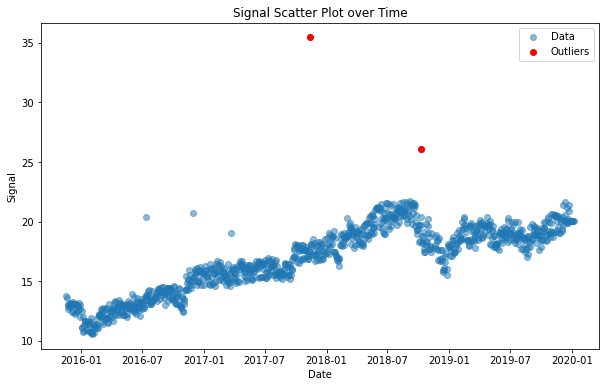

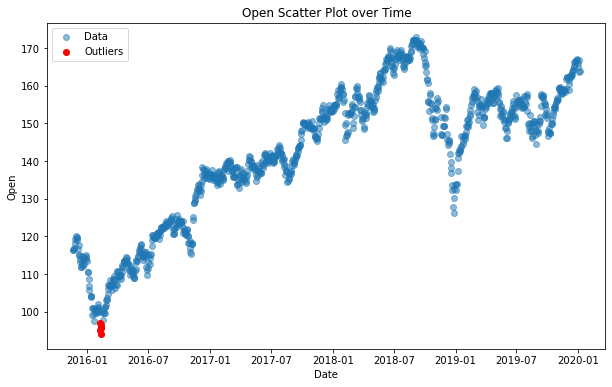

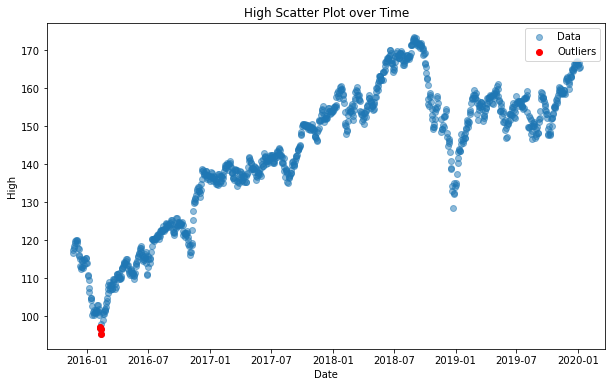

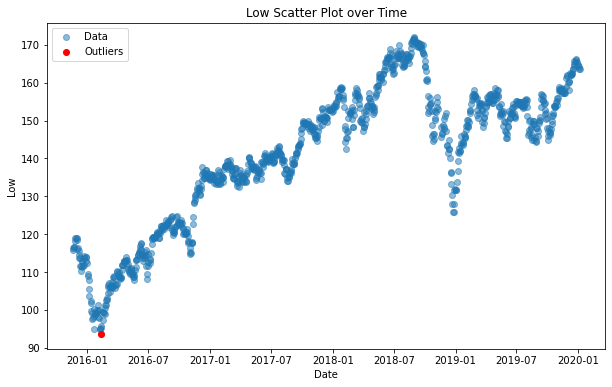

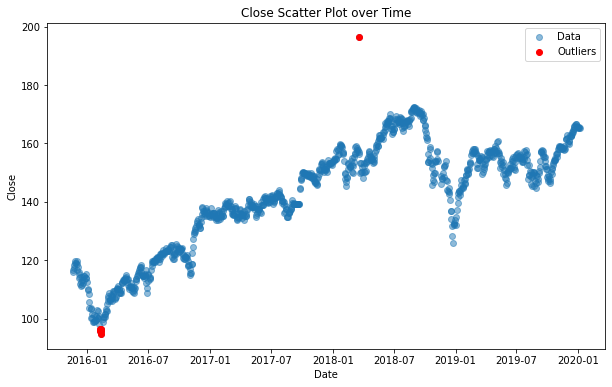

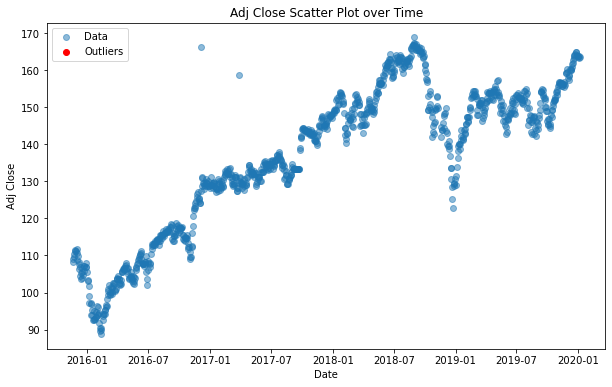

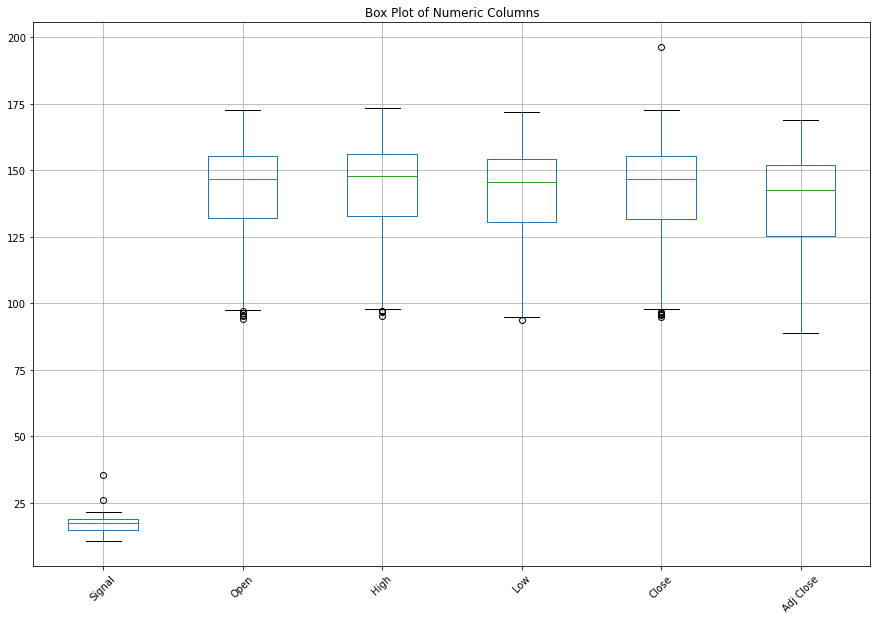

In [23]:
# Plotting outliers
plot_outliers(df_cleaned)
# TimeSeries price
# Continuous Nature:
# Time series price data is typically continuous during regular trading hours, meaning there should not have large, abrupt changes from one point to the next during this period.
# Reasons for Outliers could also be due to Low Liquidity / insufficient bid-ask limit orders on the order book especially for the After hours trading.


# After-Hours Trading:
# Prices can exhibit significant gaps between the closing price of one day and the opening price of the next trading day due to after-hours trading activities, news, earnings reports, and other factors.
# These gaps can appear as outliers when the data is visualized or analyzed.

## You can see outliers in the Signal, Close and Adjusted Close price data 

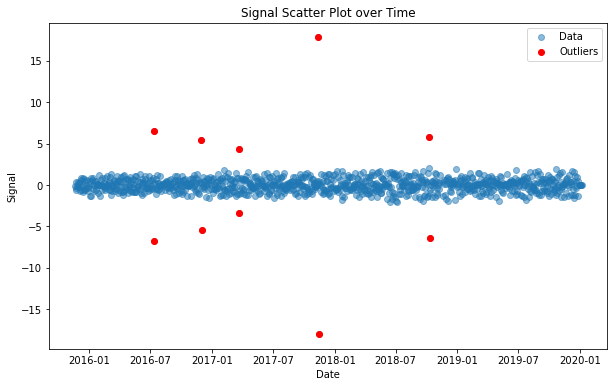

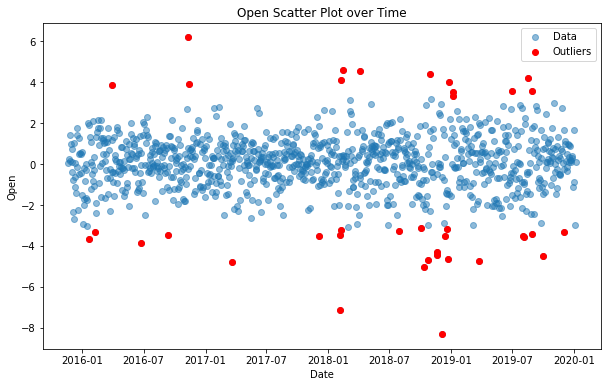

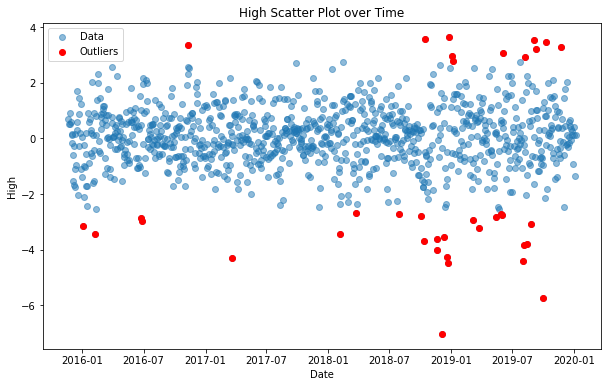

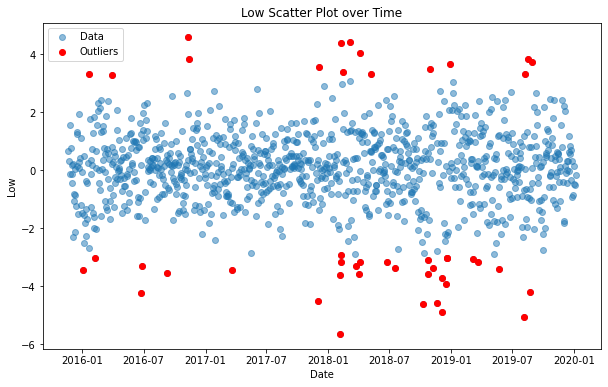

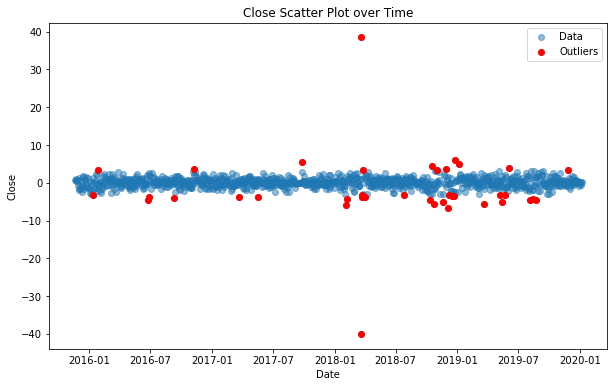

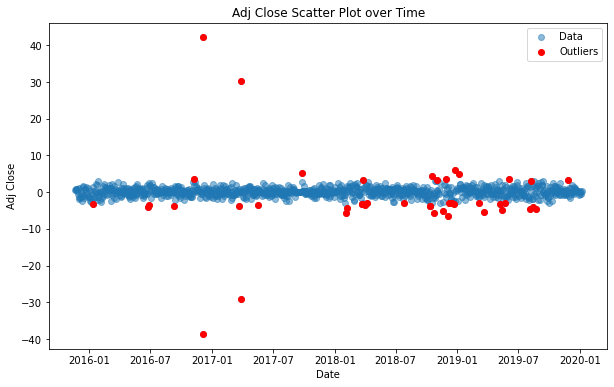

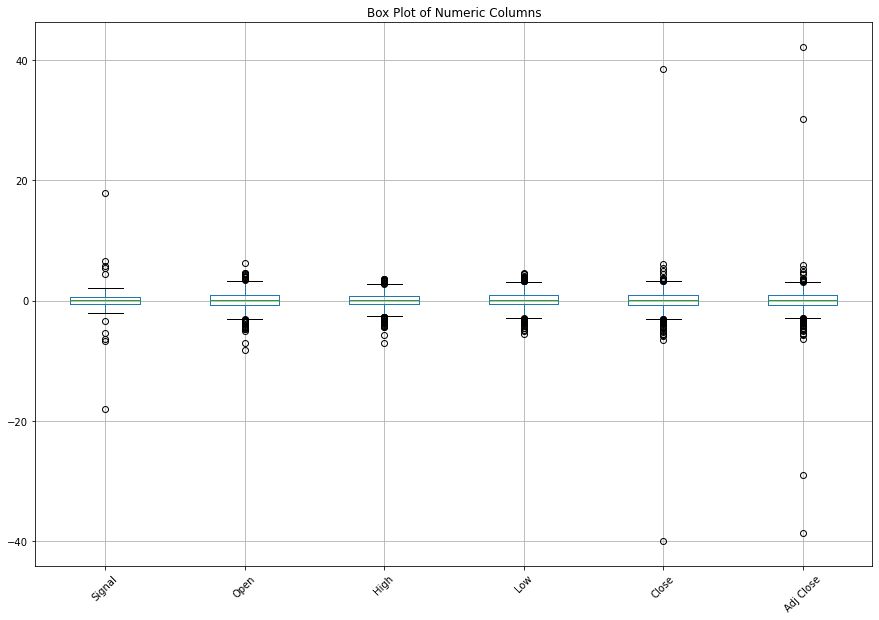

In [24]:
# Plotting outliers
plot_outliers(df_diff)

# part2 - Analyze the signal’s effectiveness
Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.


a.	Cross correlation

b.	Kurtosis & skew

c.	R2 score from Lasso, Ridge & RandomForest

d.	ACF, PACF of signal, ETF

e. MAE, MSE, RMSE, R2


## Cross-Correlation

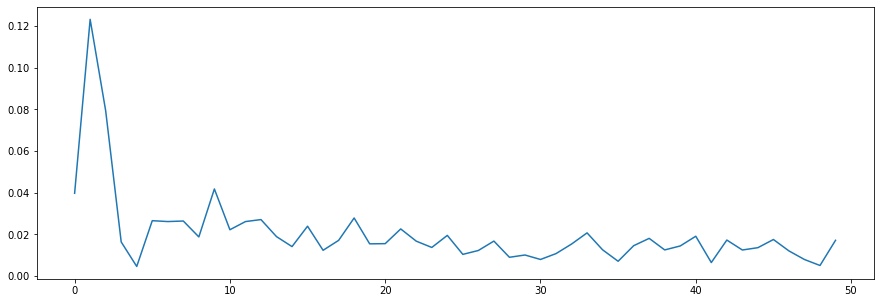

In [53]:
horizon = 50
lags = []
collated_corr = []
for h in range(1, horizon+1):
    df_diff_temp = difference_columns(df_cleaned.copy(), h)
    df_diff_lagged = df_diff_temp.copy()
    df_diff_lagged["Signal"] = df_diff["Signal"].shift(h)
    df_diff_lagged = df_diff_lagged.dropna()
    collated_corr.append(abs(np.corrcoef(df_diff_lagged["Signal"], df_diff_lagged["Adj Close"])[0][1]))
    lags.append("Lag" + str(h))

df_cross_corr = pd.DataFrame()
df_cross_corr["Lag_no"] = lags
df_cross_corr["Corr"] = collated_corr

plt.figure(figsize=(15,5))
plt.plot(df_cross_corr["Corr"])
plt.show()

## Skew & Kurtosis

In [74]:
print("Skew of Signal: " + str(stats.skew(df_diff["Signal"], axis=0, bias=True)))
print("Skew of Adjusted Close: " + str(stats.skew(df_diff["Adj Close"], axis=0, bias=True)))

Skew of Signal: -0.1337158082799805
Skew of Adjusted Close: 1.0174801842166978


In [79]:
print("Kurtosis of Signal: " + str(stats.kurtosis(df_diff["Signal"], axis=0,)))
print("Kurtosis of Adjusted Close: " + str(stats.kurtosis(df_diff["Adj Close"], axis=0)))

Kurtosis of Signal: 95.84755180288548
Kurtosis of Adjusted Close: 145.28566746406835


## Decomposing the dataset

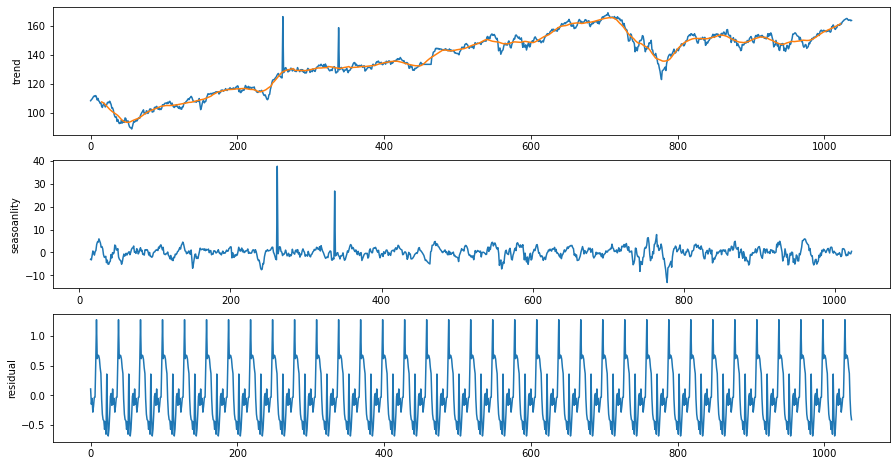

In [70]:
res = seasonal_decompose(df_cleaned["Adj Close"], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.observed.plot(ax=ax1,ylabel = "trend")
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasonality")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

## ACF/PACF

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. In other words, it measures the relationship between a variable’s current value and its past values.

PACF measures the relationship between a variable’s current value and its past values unconditional to the preceeding lags.


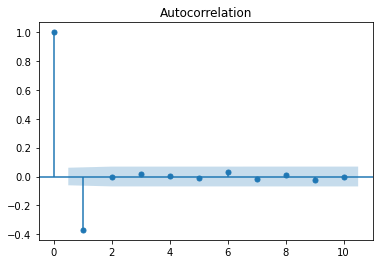

In [67]:
sm.graphics.tsa.plot_acf(df_diff["Adj Close"], lags=10)
plt.show()

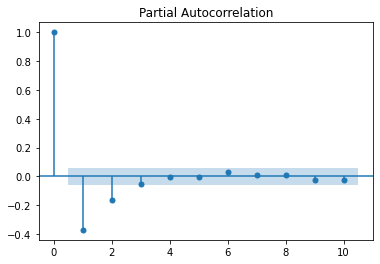

In [65]:
sm.graphics.tsa.plot_pacf(df_diff["Adj Close"], lags=10)
plt.show()

ACF is significant at lag 1, whereas PACF is shows a geometric decay at each m lag. This can signify a moving average (MA) component in an ARIMA model is used.  

## Regression


In [148]:
forecast_horizon = 1

df_for_regression = difference_columns(df_cleaned.copy(), forecast_horizon)
df_for_regression = df_for_regression.rename(columns={"Adj Close": "y"})
df_for_regression = df_for_regression.drop(columns = ["Open", "High", "Low", "Close"])

# We need to shift the features to ensure fair forecasting
df_for_regression["Signal"] = df_for_regression["Signal"].shift(forecast_horizon)

# Create lags for linear regression
lags_required = 2
for l in range(forecast_horizon, lags_required+1):
    df_for_regression["lag"+str(l)] = df_for_regression["y"].shift(l)


X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_for_regression.dropna(), test_ratio=0.2, is_time_series = True)
models_performance = {}

### Naive

In [149]:
pred = df_for_regression["y"].shift(horizon).tolist()[-len(X_test):]
score = mean_absolute_error(pred, y_test)
models_performance["Naive"] = [score, np.std(pred)]
print('MAE: %.3f (%.3f)' % (score, np.std(pred)))

MAE: 1.733 (1.589)


### Lasso

In [150]:
def get_cleaned_numerical_pipeline(features):
    numerical_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_names=features)),
        ('numerical_imputer', CustomImputer(impute_type='numerical'))
        ])
    return numerical_pipeline

features = [i for i in X_train.columns if i not in ["y", "Date"]]
features

['Signal', 'lag1', 'lag2']

In [151]:
preprocess_lr = Pipeline([
  ('clean_pipeline', get_cleaned_numerical_pipeline(features)),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])

preprocess_lr.fit(X_train, y_train)
pred = preprocess_lr.predict(X_test)

score = mean_absolute_error(pred, y_test)
models_performance["Lasso"] = [score, np.std(pred)]
print('MAE: %.3f (%.3f)' % (score, np.std(pred)))

MAE: 1.182 (0.370)


['Signal', 'lag2', 'lag1']


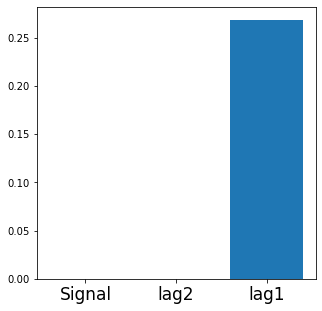

In [152]:
preprocess_lr.fit(X_train, y_train)
clean_pipeline = get_cleaned_numerical_pipeline(features)
X_train_cleaned = clean_pipeline.fit_transform(X_train)

# get importance
importance = np.abs(preprocess_lr['lasso_regressor'].coef_)
features = list(X_train_cleaned.columns)

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(5, 5))
plt.xticks(fontsize=17)

print(impt_features)
plt.bar(impt_features, impt_features_score)
plt.show()


Lasso regularised the coefficient of the signal to 0, signifying that the signal is not important in forecasting the adjusted close price 1 step forward.

### RandomForest

In [153]:
rf_lr = Pipeline([
  ('clean_pipeline', get_cleaned_numerical_pipeline(features)),
  ('rf_regressor', RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_lr.fit(X_train, y_train)
pred = rf_lr.predict(X_test)

score = mean_absolute_error(pred, y_test)
models_performance["RandomForest"] = [score, np.std(pred)]
print('MAE: %.3f (%.3f)' % (score, np.std(pred)))

MAE: 1.282 (0.694)


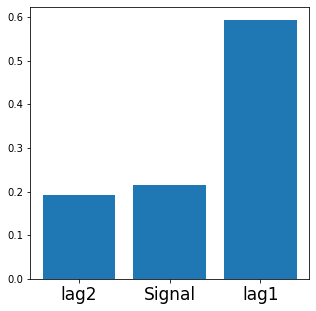

In [154]:
rf_lr.fit(X_train, y_train)
clean_pipeline = get_cleaned_numerical_pipeline(features)
X_train_cleaned = clean_pipeline.fit_transform(X_train)

# get importance
importance = rf_lr['rf_regressor'].feature_importances_
features = list(X_train_cleaned.columns)

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(5,5))
plt.xticks(fontsize=17)

plt.bar(impt_features, impt_features_score)
plt.show()


In [155]:
pd.DataFrame.from_dict(models_performance, orient='index', columns=["MAE", "STD"])

,MAE,STD
Naive,1.733500,1.588534
Lasso,1.182136,0.370452
RandomForest,1.281605,0.694286


# part3 
Run any exploratory data analysis you think is important and highlight any interesting insights you come across.

a.	Uhhh same as parts 1 &2 unless yall can think of smth else




volatility analysis - bollinger bands

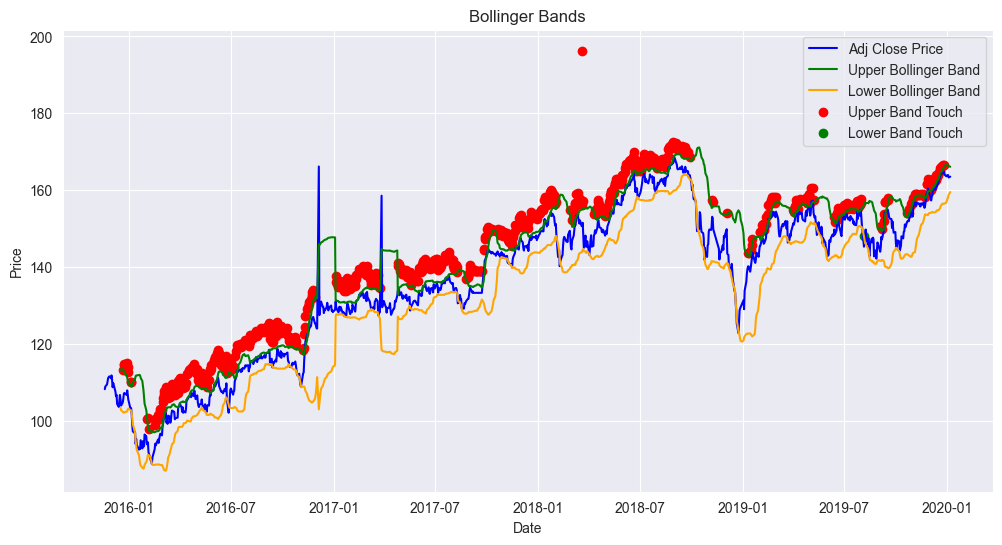

In [47]:
df_bollinger = df_cleaned.copy()
df_bollinger['Date'] = pd.to_datetime(df_bollinger['Date'])
df_bollinger = df_bollinger.set_index('Date').asfreq('D').dropna() 



# Calculate 20-day moving average
df_bollinger['MA20'] = df_bollinger['Adj Close'].rolling(window=20).mean()

# Calculate standard deviation
df_bollinger['std_dev'] = df_bollinger['Adj Close'].rolling(window=20).std()

# Calculate upper and lower Bollinger Bands
df_bollinger['upper_band'] = df_bollinger['MA20'] + (2 * df_bollinger['std_dev'])
df_bollinger['lower_band'] = df_bollinger['MA20'] - (2 * df_bollinger['std_dev'])

# Plot the stock prices and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df_bollinger.index, df_bollinger['Adj Close'], label='Adj Close Price', color='blue')
plt.plot(df_bollinger.index, df_bollinger['upper_band'], label='Upper Bollinger Band', color='green')
plt.plot(df_bollinger.index, df_bollinger['lower_band'], label='Lower Bollinger Band', color='orange')


# Highlight points where the close price touches the upper Bollinger Band
upper_touch_points = df_bollinger[df_bollinger['Close'] >= df_bollinger['upper_band']]
plt.scatter(upper_touch_points.index, upper_touch_points['Close'], color='red', marker='o', label='Upper Band Touch')

# Highlight points where the close price touches the lower Bollinger Band
lower_touch_points = df_bollinger[df_bollinger['Close'] <= df_bollinger['lower_band']]
plt.scatter(lower_touch_points.index, lower_touch_points['Close'], color='green', marker='o', label='Lower Band Touch')

plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[Return to the Top](#part1-)